In [1]:
import os, sys

import IPython.display as ipd

path= '/Users/sbielfel/Nextcloud2/time_resolved/'
sys.path.append(path)
path= '/Users/sbielfel/Nextcloud2/phase_retrieval/algos/'
sys.path.append(path)
%load_ext autoreload
%autoreload 2

In [2]:
print(sys.executable)

/Users/sbielfel/anaconda3/envs/fml/bin/python


In [3]:
# import h5py
import meteor
import reciprocalspaceship as rs
import numpy as np
import gemmi 
import ipywidgets as widgets
from scipy.ndimage import gaussian_filter
# from output_eval import *

In [4]:
from occupancy import *
from plotting3d import *

In [5]:
%matplotlib ipympl
%matplotlib inline

In [6]:
variant = "realmeteor"
noise_level=0
plotfolder = "./plots/"

In [7]:

pdbloc = "../synthetic_cistrans/"
mtzloc = "../X8_runs/X8_test_1/"
name_dark = "k.mtz"
name_light = "on.mtz"
ds_light = rs.read_mtz(mtzloc+name_light)
ds_dark = rs.read_mtz( mtzloc+name_dark)

In [8]:
ds_dark

F_k    SIGF_k       PHI_k  FreeR_flag
H  K  L                                              
0  0  4     4.29962  3.383419    0.000019           0
      6    2.132432  1.672898 -179.999985           0
      8     0.71406  1.478825 -179.999985           0
      10   2.368493  1.226426     0.00001           0
      12     1.2202  2.018752    0.000019           0
...             ...       ...         ...         ...
34 11 6    0.193971  3.499082  -172.86795           0
   12 2    0.102222  2.618628    8.407731           0
      5    2.323771  3.263322  125.263443           0
35 2  0   13.340703  2.834864  -89.999992           0
      4    7.026342  3.547688  -87.212669           0

[41429 rows x 4 columns]

In [9]:
ds_dark["sf"] = ds_dark.to_structurefactor("F_k", "SIGF_k")
f_dark_comp = ds_dark.to_reciprocal_grid("sf")
# ds_light["sf"] = ds_light.to_structurefactor("FC", "PHIC")
# f_light = ds_light.to_reciprocal_grid("sf")
# delta_fa_abs = np.abs(f_light)-np.abs(f_dark)

In [10]:
ds_dark["sf"] = ds_dark.to_structurefactor("F_k", "PHI_k")
f_dark = ds_dark.to_reciprocal_grid("sf")
f_dark_abs = np.abs(f_dark)

In [11]:
def add_friedel_pairs(rs_dataset, col, fshape):
    rs_dataset = rs_dataset.expand_to_p1()
    f_out = np.zeros(fshape)
    for hkl,v in rs_dataset[col].items():
        f_out[tuple(hkl)] = v
        inv_hkl = -np.array(hkl)%fshape
        f_out[tuple(inv_hkl)] = v
    return f_out
fshape = np.array(f_dark.shape)
f_light_abs = add_friedel_pairs(ds_light,"F_on", fshape)

In [12]:
delta_fa_abs = f_light_abs-np.abs(f_dark)

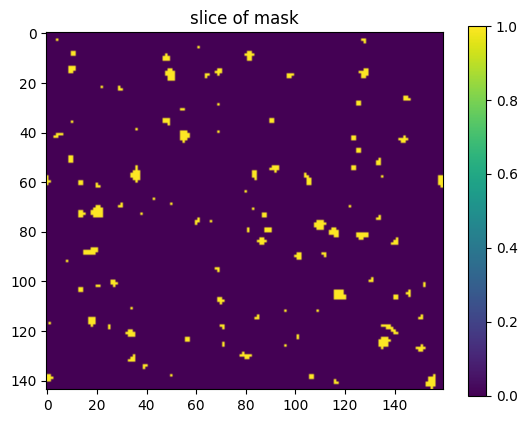

In [13]:
# flipped compared to normal order!!!
# np.flip(obj, (0,1,2)) to adjust
f_light_0 = np.abs(f_light_abs)*np.exp(1j*np.angle(f_dark))
obj1 = np.real(np.fft.ifftn(f_light_0))
obj0 = np.real(np.fft.ifftn(f_dark))

delta_obj = obj1-obj0

mask_pks = np.abs(delta_obj)>0.005
plt.figure()
plt.imshow(delta_obj[7])
plt.imshow(mask_pks[7])
plt.colorbar()
plt.title("slice of mask")
plt.show()

In [16]:
pdbname_light = pdbloc+"100ps.pdb"
struc_light = gemmi.read_structure(pdbname_light)
pdbname_dark = pdbloc + "trans.pdb"
struc_dark = gemmi.read_structure(pdbname_dark)

pos_list = np.array([(rca.atom.pos).tolist()   for rca in struc_light[0].all()])
for idx in range(3):
    diff = np.max(pos_list[:,idx])-np.min(pos_list[:,idx])


Text(0.5, 0, 'Occupancy')

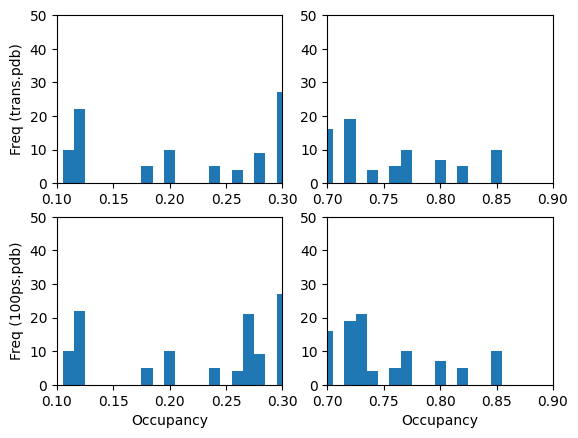

In [18]:
plt.close("all")
fig, axs = plt.subplots(2,2)
ax =axs[0,0]
bins = np.linspace(0.005,1.005,101)
for ax in axs.flat:
    ax.set_ylim(0,50)
    
ax =axs[0,0]
ax.hist([np.round(x.atom.occ,2) for x in struc_dark[0].all()], bins = bins)
ax.set_xlim(.1,.3)
ax.set_ylabel("Freq (trans.pdb)")

ax =axs[1,0]
ax.hist([np.round(x.atom.occ,2) for x in struc_light[0].all()], bins = bins)
ax.set_xlim(.1,.3)
ax.set_ylabel("Freq (100ps.pdb)")
ax.set_xlabel("Occupancy")

ax =axs[0,1]
ax.hist([np.round(x.atom.occ,2) for x in struc_dark[0].all()], bins = bins)
ax.set_xlim(.7,.9)

ax =axs[1,1]
ax.hist([np.round(x.atom.occ,2) for x in struc_light[0].all()], bins = bins)
ax.set_xlim(.7,.9)
ax.set_xlabel("Occupancy")


basically I am just checking that the occupancies are where you promised them to be - and that nothing else occupies this occupancy range.

interactive(children=(IntSlider(value=0, description='f0', max=119), Output()), _dom_classes=('widget-interact…

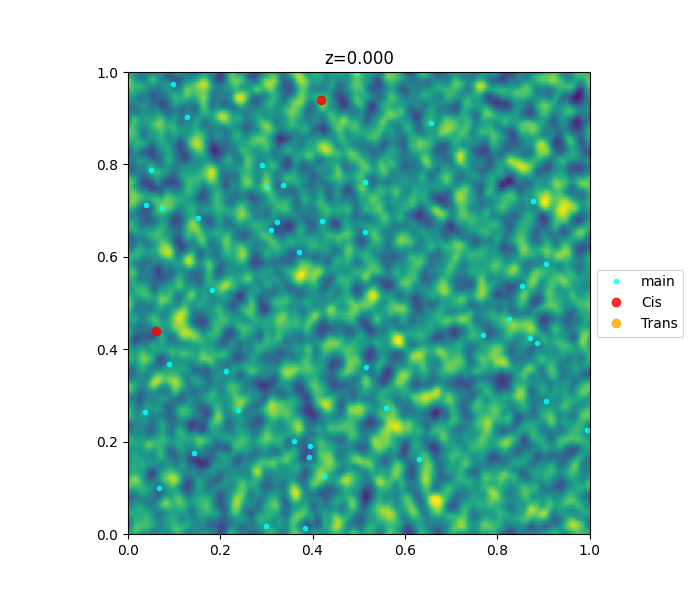

In [19]:
from plotting3d import get_pos_from_pdb
frac_list, occ_mask=get_pos_from_pdb(struc_light, search_occ=0.27)
%matplotlib widget
if True:
    mtz_comp(frac_list,occ_mask,  np.flip(obj1-obj0,(0,1,2)),extent=[0,1,1,0]) 
else:
    mtz_comp(frac_list,occ_mask,  np.flip(obj1,(0,1,2)),extent=[0,1,1,0], gif_name="gifs/match_pdbmtz.gif")



In [20]:
# slice_3d(np.flip(obj1-obj0,(0,1,2))[32:58, 50:76, 65:90])

In [21]:
obj1.shape

(120, 144, 160)

Making sure that I understand the data and a way to find alternative conformations

interactive(children=(IntSlider(value=0, description='f0', max=119), Output()), _dom_classes=('widget-interact…

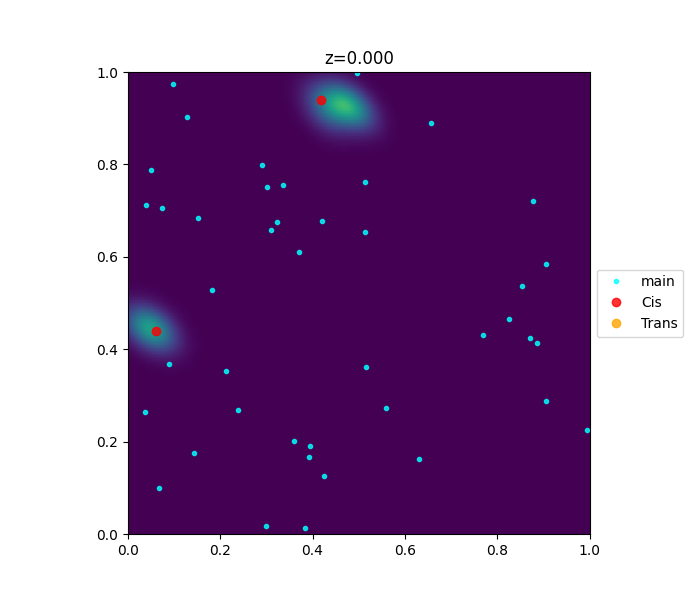

In [22]:
from scipy import stats
def make_blurred(frac_pos, grid_shape,radius= .01):
    frac_pos = frac_pos.T
    X, Y, Z = np.mgrid[
        0 : 1 : grid_shape[0] * 1j,
        0 : 1 : grid_shape[1] * 1j,
        0 : 1 : grid_shape[2] * 1j,
    ]
    grid = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])

    kernel = stats.gaussian_kde(frac_pos, radius)
    density = np.reshape(kernel(grid).T, X.shape)
    return density
out = make_blurred(frac_list[occ_mask>0],obj1.shape, radius=0.1)

vv = "mtz_style"
match vv:
    case "normal":
        extent = [0,1,1,0]
        mtz_comp(frac_list,occ_mask, out, extent=extent)
    case "mtz_style":
        extent = [1,0,0,1]
        out = np.flip(out,(0,1,2))
        mtz_comp(frac_list,occ_mask, out[::-1], extent=extent)


curiously the ordering was a bit fidely.

## Angle Approximation Check
Should be lower than 0.25

In [23]:
np.round(np.sum(np.abs(delta_fa_abs)) / np.sum(np.abs(f_dark)),3)

np.float64(1.967)

# Start of the actual analysis

In [26]:
alpha_xtrs = np.linspace(0,1,20)+1e-10
f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light_abs, np.angle(f_dark),  version=2, noise_level = 0)
corr_x8 = x8_inspired(np.abs(f_dark),np.abs(f_light), np.abs(f_xtrs))

Easier than my above attempt is of course to just calculate the difference of the two phased objects.

/Users/sbielfel/Nextcloud2/time_resolved/occupancy-estimation/plotting3d.py:162: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))


interactive(children=(IntSlider(value=0, description='f0', max=119), Output()), _dom_classes=('widget-interact…

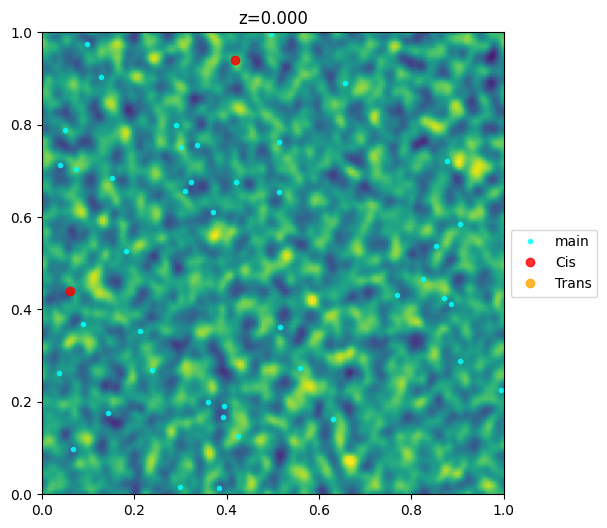

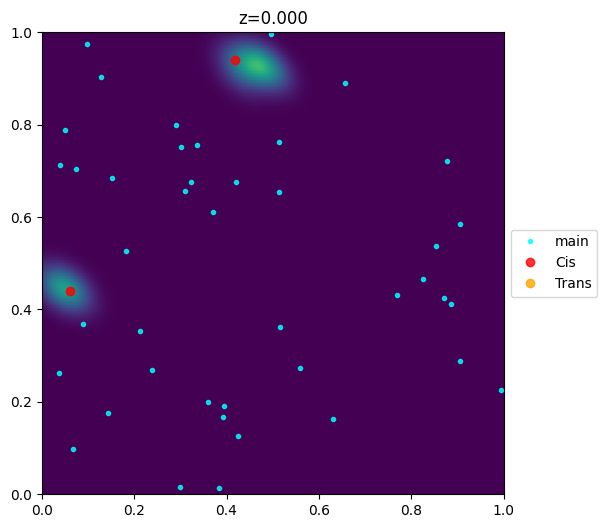

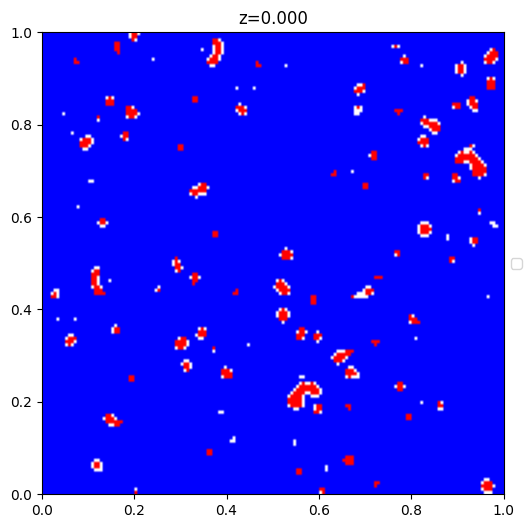

In [27]:
mask_pks_filt = gaussian_filter(np.array(mask_pks,float), 1)>.2
%matplotlib inline
slice_3d(mask_pks_filt+np.array(mask_pks,float))

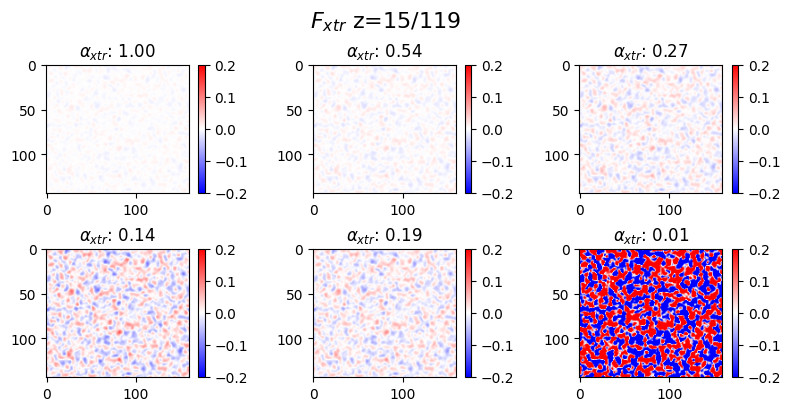

interactive(children=(IntSlider(value=15, description='f0', max=119), Output()), _dom_classes=('widget-interac…

MovieWriter ffmpeg unavailable; using Pillow instead.


gifs/realmeteor_fxtr.gif


In [30]:
    
alphax = 0.27
alpha_xtrs_vis = np.array([1, alphax*2, alphax, alphax/2,0.19, 0.01])
f_xtrs = make_f_xtr(alpha_xtrs_vis, f_dark, f_light, np.angle(f_dark),  version=1, noise_level=0)
dens_xtrs, neg_sum = marius(f_xtrs)
    
from plotting3d import show_xtrs
%matplotlib inline
anim = show_xtrs(dens_xtrs, alpha_xtrs_vis, obj0, version="only", variant=variant, make_gif=True)


In [31]:
%matplotlib inline
if False:
    for version in ["only", "diff", "diffnorm" , "diffxtr"]:
        anim = show_xtrs(dens_xtrs, alpha_xtrs_vis, obj0, alpha, 
                         version=version, variant=variant, make_gif=True)
        


NameError: name 'alpha' is not defined

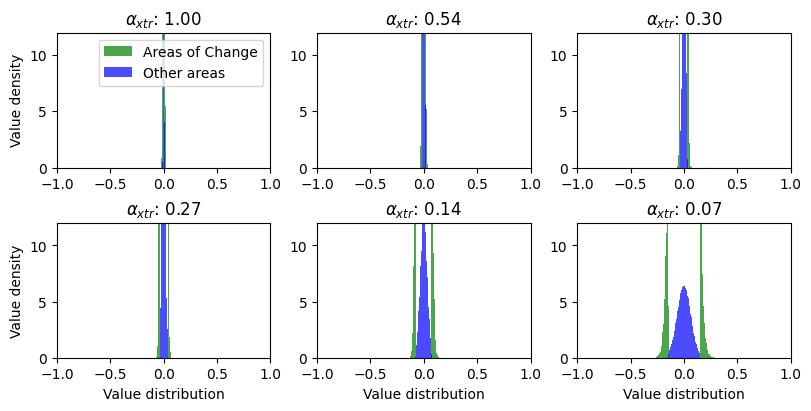

In [32]:
def show_hist():
    alphax = 0.27
    alpha_xtrs_vis = np.array([1, alphax*2, 0.3, alphax, alphax/2,alphax/4])
    f_xtrs = make_f_xtr(alpha_xtrs_vis, f_dark, f_light, np.angle(f_dark),  version=1, noise_level=0)
    dens_xtrs, neg_sum = marius(f_xtrs)
    fig, axs = plt.subplots(2,3, figsize=(8,4),constrained_layout=True)
    ims = []
    for ax, alpha_xtr, arr in zip(axs.flat, alpha_xtrs_vis,dens_xtrs):
        raw = [r"$\alpha_{xtr}$",
               r"$\alpha_t$"]
        tit = f"{raw[0]}: {alpha_xtr:.2f}"
        ax.set_title(tit)
        ax.set_ylim(0,12)
        ax.set_xlim(-1,1)
        bins = np.linspace(np.min(arr), np.max(arr), 30)
        bins = np.linspace(np.min(dens_xtrs), np.max(dens_xtrs), 100)
        arr = arr-obj0
        ax.hist(arr[mask_pks],color="green", alpha=0.7, density=True, bins= bins, label="Areas of Change")
        ax.hist(arr[~mask_pks], color = "blue", alpha=0.7, density=True, bins= bins, label = "Other areas")
        # fig.suptitle(title + f" z={f0}/{imlen-1}", fontsize=16)    
    axs[0,0].legend()
    for ax in [axs[0,0],axs[1,0]]:
        ax.set_ylabel("Value density")
    for ax in axs[1]:
        ax.set_xlabel("Value distribution")
    fig.suptitle("Value Distribution $F_{xtr}$ - Area of Change vs. overall \t"
                 + r"$\alpha_{true}$="+str(alpha))
show_hist()


In [34]:
alpha_invs = (np.arange(0,20)+1e-10)
alpha_xtrs = 2/alpha_invs

f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light_abs, np.angle(f_dark),  version=1, noise_level = 0)
dens_xtrs, neg_sum = marius(f_xtrs)


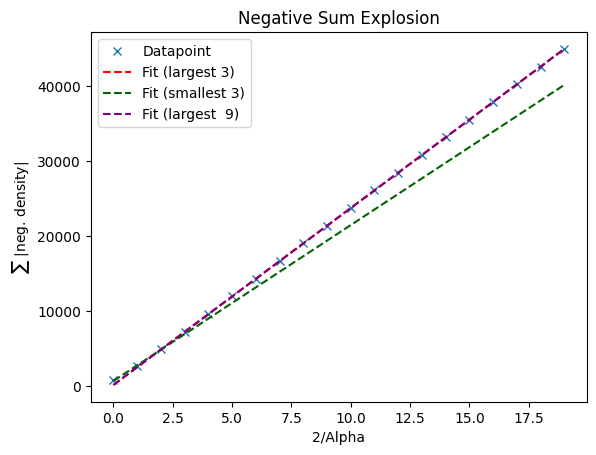

In [35]:
from scipy import stats
n_largest = 3
n_more = 9
m1 = alpha_invs>alpha_invs[-n_largest]
m2 = alpha_invs<alpha_invs[n_largest]
res_1 = stats.linregress(alpha_invs[m1], -neg_sum[m1])
res_2 = stats.linregress(alpha_invs[m2], -neg_sum[m2])
m11 = alpha_invs>alpha_invs[-n_more]
m22 = alpha_invs<alpha_invs[n_more]
res_11 = stats.linregress(alpha_invs[m11], -neg_sum[m11])
res_22 = stats.linregress(alpha_invs[m22], -neg_sum[m22])

alpha_line = np.linspace(np.min(alpha_invs), np.max(alpha_invs),5,)

fig = plt.figure()
plt.plot(alpha_invs,neg_sum*-1, "x",  label="Datapoint")


plt.plot(alpha_line, res_1.intercept+res_1.slope*alpha_line,c="red",linestyle="--", label=f"Fit (largest {n_largest})")
plt.plot(alpha_line, res_2.intercept+res_2.slope*alpha_line, c="darkgreen",linestyle="--",label=f"Fit (smallest {n_largest})")
plt.plot(alpha_line, res_11.intercept+res_11.slope*alpha_line,c="purple",linestyle="--", label=f"Fit (largest  {n_more})")
# plt.plot(alpha_line, res_22.intercept+res_22.slope*alpha_line, c="purple",linestyle="--")
plt.legend()
plt.xlabel("2/Alpha")
plt.ylabel(r"$\sum$ |neg. density|")
plt.title("Negative Sum Explosion")
from plotting3d import fname_variant
loc = plotfolder+fname_variant(variant)
fig.savefig(loc + "_negsumexplosion.png")


interestingly, the results for this are better/more consistent with noise rather than without.

[1.04516827 1.05088242]


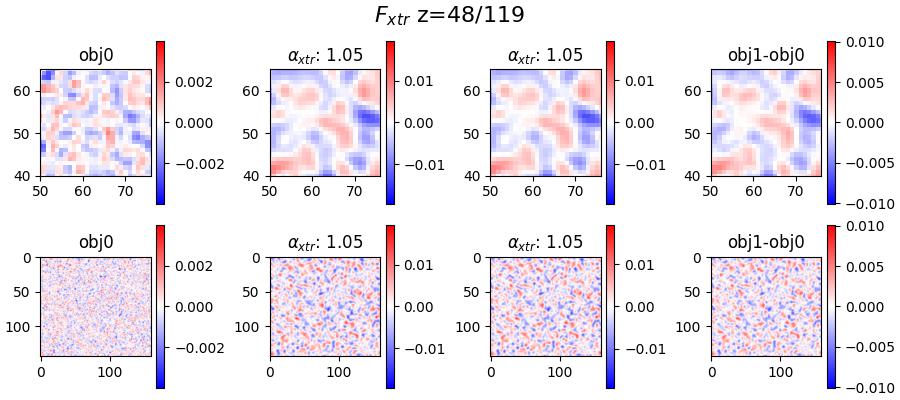

interactive(children=(IntSlider(value=48, description='f0', max=119), Output()), _dom_classes=('widget-interac…

In [39]:
# slice_3d(np.flip(obj1-obj0,(0,1,2))[32:58, 50:76, 65:90])
intersection = (res_2.intercept-res_1.intercept) / (res_1.slope-res_2.slope)
alpha_intersect = 2/intersection
intersection = (res_2.intercept-res_11.intercept) / (res_11.slope-res_2.slope)
alpha_intersect2 = 2/intersection

alpha_xtrs_vis = np.array([alpha_intersect, alpha_intersect2])
f_xtrs = make_f_xtr(alpha_xtrs_vis, f_dark, f_light_abs, np.angle(f_dark),  version=1, noise_level=0)
dens_xtrs, neg_sum = marius(f_xtrs)
print(alpha_xtrs_vis)
plt.close('all')
%matplotlib widget
anim = direct_comp(
    dens_xtrs,
    alpha_xtrs_vis,
    obj0,
    obj1,
    version="only",
    idx=48,
    make_gif=False
) 

In [40]:
from occupancy import  x8_density_map_fdiff_norm

alpha_xtrs = np.linspace(5e-2,1,100 )

f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_dark),  version=1, noise_level=0)
peak_sum, real_CC = x8_density_map_f1(f_xtrs, mask_pks, obj0, delta_obj)
peak_sum_diff, real_CC_diff = x8_density_map_fdiff(f_xtrs, mask_pks, obj0, delta_obj)
peak_sum_diffnorm, real_CC_diffnorm = x8_density_map_fdiff_norm(f_xtrs, mask_pks, obj0, delta_obj)

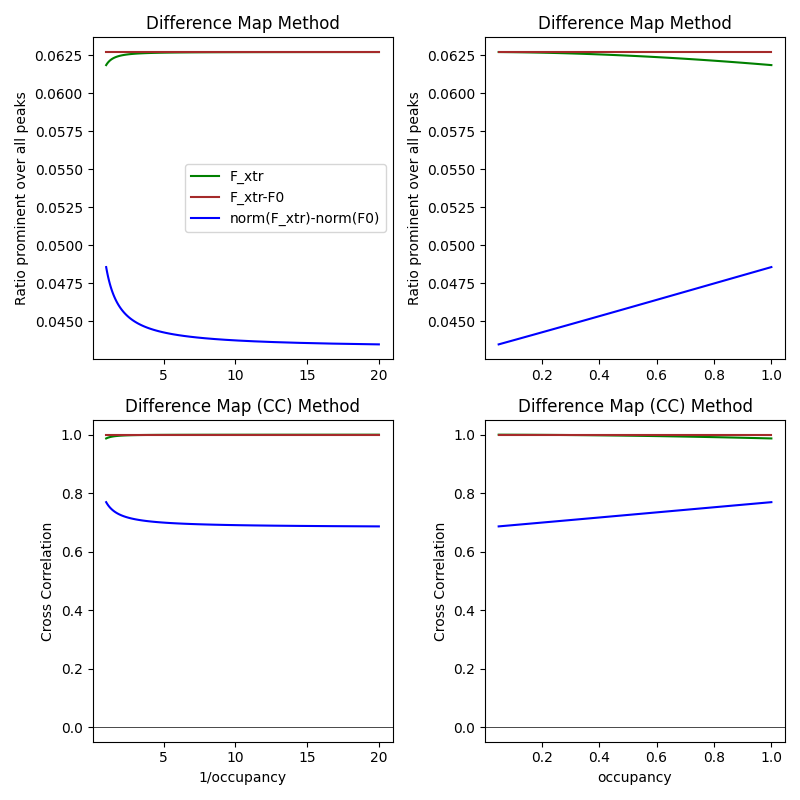

In [43]:
fig, axs = plt.subplots(2,2, figsize=(8,8),tight_layout=True)
for ax in axs[0] :
    ax.set_ylabel("Ratio prominent over all peaks")
    ax.set_title("Difference Map Method")
    
for ax in axs[1] :
    ax.axhline(0,c="k", linewidth=.5, )
    ax.set_ylabel("Cross Correlation")
    ax.set_xlabel("Alphas")
    ax.set_title("Difference Map (CC) Method")

ax = axs[0,0]
ax.plot(1/alpha_xtrs,peak_sum, label=r"F_xtr",color="g")
ax.plot(1/alpha_xtrs,peak_sum_diff, label=r"F_xtr-F0",color="brown")
ax.plot(1/alpha_xtrs,peak_sum_diffnorm, label=r"norm(F_xtr)-norm(F0)",color="b")
ax.legend()

ax = axs[0,1]
ax.plot(alpha_xtrs,peak_sum, label=r"$\phi_{0}$",color="g")
ax.plot(alpha_xtrs,peak_sum_diff, label=r"$\phi_{0}$",color="brown")
ax.plot(alpha_xtrs,peak_sum_diffnorm, label=r"norm(F_xtr)-norm(F0)",color="b")

ax = axs[1,0]
ax.plot(1/alpha_xtrs,real_CC, label=r"$\phi_{0}$",color="g")
ax.plot(1/alpha_xtrs,real_CC_diff, label=r"F_xtr-F0",color="brown")
ax.plot(1/alpha_xtrs,real_CC_diffnorm, label=r"norm: F_xtr-F0",color="b")
ax.set_xlabel("1/occupancy")

ax = axs[1,1]
ax.plot(alpha_xtrs,real_CC,  label=r"F_xtr"    ,    color="g")
ax.plot(alpha_xtrs,real_CC_diff, label=r"F_xtr-F0",color="brown")
ax.plot(alpha_xtrs,real_CC_diffnorm, label=r"norm: F_xtr-F0",color="b")
ax.set_xlabel("occupancy")

loc = plotfolder+fname_variant(variant)
fig.savefig(loc + "_differencemap.png")

I think I said quite a bit about it in the previous text. Here I don't have much to add.

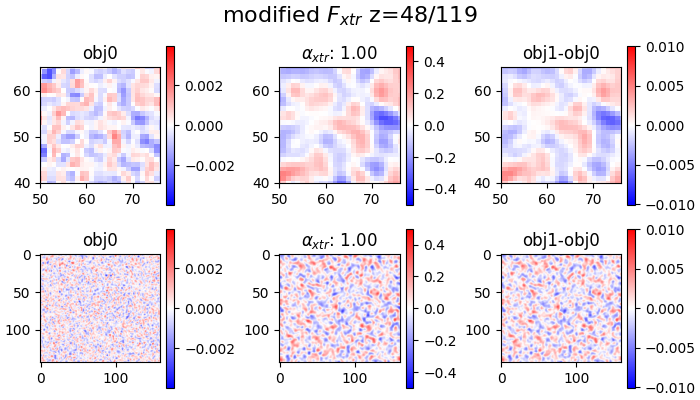

interactive(children=(IntSlider(value=48, description='f0', max=119), Output()), _dom_classes=('widget-interac…

In [46]:
pk_val = alpha_xtrs[np.argmax(peak_sum_diffnorm)]
pk_val

alpha_xtrs_vis = np.array([pk_val])
f_xtrs = make_f_xtr(alpha_xtrs_vis, f_dark, f_light, np.angle(f_dark),  version=1, noise_level=0)
dens_xtrs, neg_sum = marius(f_xtrs)

direct_comp(
    dens_xtrs,
    alpha_xtrs_vis,
    obj0,
    obj1,
    version="diffxtr",
    idx=48
) 


/Users/sbielfel/Nextcloud2/time_resolved/occupancy-estimation/plotting3d.py:162: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))


interactive(children=(IntSlider(value=0, description='f0', max=119), Output()), _dom_classes=('widget-interact…

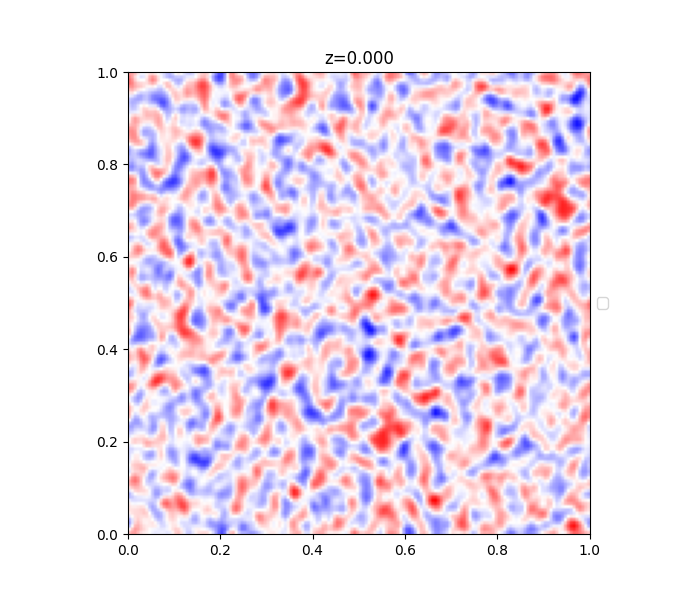

In [71]:
delta_obj = obj1-obj0
strict = 0.01
lax = 0.006
mask_pks = gaussian_filter(np.abs(delta_obj),1)>0.01
mask_pks_strict = np.abs(delta_obj)>strict
mask_pks_lax = np.abs(delta_obj)>lax
mask_pks_filt = gaussian_filter(np.array(mask_pks,float), 1)>.9
mask_pks = np.abs(delta_obj)>0.06
# slice_3d(delta_obj, cmap='bwr',vmin=-np.max(delta_obj), vmax=np.max(delta_obj))
slice_3d(delta_obj)
# ([delta_obj,mask_pks_filt],rows=1, cols=2)


Text(0, 0.5, 'Frequency')

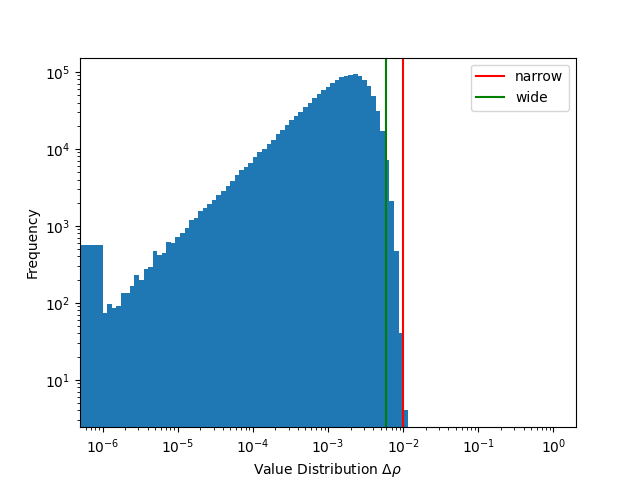

In [72]:
bins = np.logspace(-6,0,100)
bins = np.concatenate([[0], bins])
plt.figure()
plt.hist(delta_obj.flatten(),bins=bins)
plt.axvline(strict, label="narrow", color="r")
plt.axvline(lax, label="wide", color='g')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"Value Distribution $\Delta \rho$")
plt.ylabel("Frequency")

In [73]:
alpha_xtrs = np.linspace(5e-2,1,50 )
f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light_abs, np.angle(f_dark),  version=1, noise_level=0)
mean_local_lax, mean_global_lax = pandda(f_dark, f_xtrs, mask_pks_lax)
mean_local_strict, mean_global_strict = pandda(f_dark, f_xtrs, mask_pks_strict)


In [74]:
f_dark.shape,f_light.shape


((120, 144, 160), (120, 144, 160))

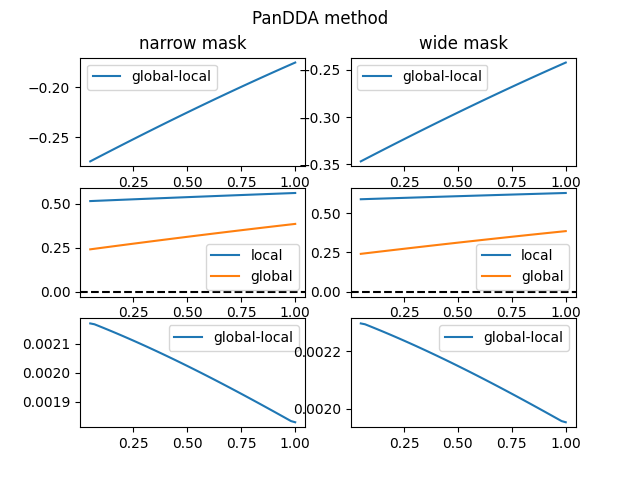

In [77]:
mean_local, mean_global =  mean_local_strict, mean_global_strict
# mean_local, mean_global =  mean_local_lax, mean_global_lax
ml = [mean_local_strict, mean_local_lax]
mg = [mean_global_strict, mean_global_lax]
titles = ["narrow mask", "wide mask"]

fig, axso = plt.subplots(3,2)
for axs, mean_local, mean_global, title in zip(axso.T, ml, mg, titles):
    ax = axs[0]
    ax.set_title(title)
    ax.plot(alpha_xtrs,+mean_global-mean_local, label="global-local") 
    ax.legend()
    ax = axs[1]
    ax.axhline(0,c="k", linestyle="--")
    ax.plot(alpha_xtrs,mean_local, label="local") 
    ax.plot(alpha_xtrs, mean_global,label="global")
    ax.legend()
    ax = axs[2]
    # ax.axvline(alpha/2,c="k", linestyle="-", label="1/2*alpha_true")
    # ax.axvline(alpha*2,c="k", linestyle="--", label="2*alpha_true")
    ax.plot(alpha_xtrs,+np.gradient(mean_global-mean_local), label="global-local") 
    ax.legend()

fig.suptitle("PanDDA method")
loc = plotfolder+fname_variant(variant)
fig.savefig(loc + "_pandda.png")

Here, too, results look better for the case of noise. Weird. That is assuming one knows the most crucial regions of change.

Also, here it is far from 0 correlation at the correct occupancy. This makes the underlying assumption motivation seam rather brittle.

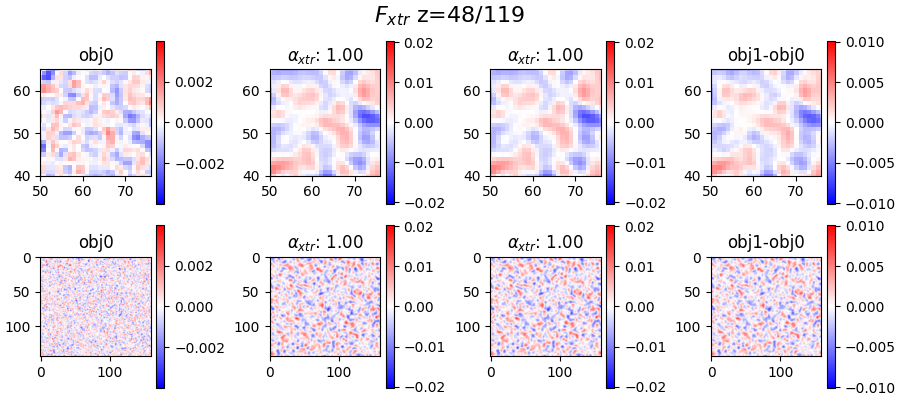

interactive(children=(IntSlider(value=48, description='f0', max=119), Output()), _dom_classes=('widget-interac…

MovieWriter ffmpeg unavailable; using Pillow instead.


gifs/realmeteor_dcomp__fxtr.gif


In [79]:
pk_strict = alpha_xtrs[np.argmax(mean_global_strict-mean_local_strict)]
pk_lax = alpha_xtrs[np.argmax(mean_global_lax-mean_local_lax)]

alpha_xtrs_vis = np.array([pk_lax, pk_strict])
f_xtrs = make_f_xtr(alpha_xtrs_vis, f_dark, f_light, np.angle(f_dark),  version=1, noise_level=0)
dens_xtrs, neg_sum = marius(f_xtrs)

direct_comp(
    dens_xtrs,
    alpha_xtrs_vis,
    obj0,
    obj1,
    version="only",
    variant=variant,
    idx=48,
    make_gif = True
) 
